In [ ]:
import torch # Główna biblioteka do tworzenia sieci neuronowych
import torch.nn as nn # Narzędzia do budowy modeli neuronowych
import torch.optim as optim # Moduł z różnymi optymalizatorami dla wag modelu
from torch.utils.data import DataLoader # Pozwala obrazy z folderu załadować do sieci
from torchvision import transforms, datasets # Narzędzia do robienia zmian na obrazach
import matplotlib.pyplot as plt # Biblioteka do rysowania wykresów
# Importowanie biblioteki do obliczeń numerycznych w Pythonie
import numpy as np
from torchvision import transforms, datasets
from torchvision.transforms import v2
import torch.nn.functional as F


The aim of project is to classify diffrent ball types. Dataset:
https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification

In [2]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1)), # Normalizacja wartości pikseli
])

transform_train = transforms.Compose([
     transforms.Resize((300, 300)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(90),
     transforms.ToTensor(),
     transforms.Normalize((0, 0, 0), (1, 1, 1)),
     v2.GaussianNoise(0,0.1),
]
)

train_dataset = datasets.ImageFolder(root='C:/Users/Lenovo/Desktop/projekt ML/train',transform=transform_train)
validation_dataset = datasets.ImageFolder(root='C:/Users/Lenovo/Desktop/projekt ML/valid',transform=transform)

test_dataset = datasets.ImageFolder(root='C:/Users/Lenovo/Desktop/projekt ML/test',transform=transform)
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)

# Sprawdzenie długości zestawów danych i liczby klas
print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')
print(f'Validation dataset size: {len(validation_dataset)}')
print(f'Number of classes: {len(train_dataset.classes)}')

Training dataset size: 6288
Testing dataset size: 1841
Validation dataset size: 1040
Number of classes: 15


In [18]:
X_train = train_dataset.imgs
X_test = test_dataset.imgs
y_train = train_dataset.class_to_idx
y_test = train_dataset.class_to_idx

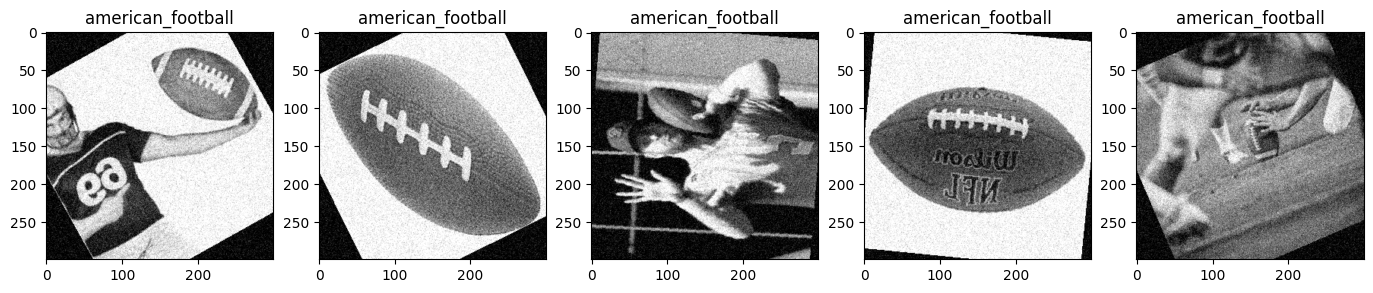

In [3]:
N_IMAGES = 5

fig, ax = plt.subplots(1, N_IMAGES, figsize=(17,7))
classes = train_dataset.classes
for i in range(N_IMAGES):
    im, lbl = train_dataset[i]

    ax[i].imshow(im[0,:,:], 'gray', interpolation='bilinear')
    ax[i].set_title(f'{classes[lbl]}')

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels,out_channels,stride=1, downsample=None):
       super(ResidualBlock, self).__init__()
       self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
       self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
       self.downsample = downsample
       self.relu = nn.ReLU()
       self.out_channels = out_channels
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
                residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.inplanes=64
        self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self.make_layer(block, 32, layers[0], stride = 1)
        self.layer1 = self.make_layer(block, 64, layers[1], stride = 2)
        self.layer2 = self.make_layer(block, 64, layers[2], stride = 2)
        self.layer3 = self.make_layer(block, 64, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(1024, 15)

    def make_layer(self, block, planes, blocks, stride=1 ):
         downsample = None
         if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
         layers = []
         layers.append(block(self.inplanes, planes, stride, downsample))
         self.inplanes = planes
         for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [5]:
#Wersja odpowiednia do uruchomienia modelu ResNt 50 accuracy

class ResidualBlock(nn.Module):
    def __init__(self, in_channels,out_channels,stride=1, downsample=None):
       super(ResidualBlock, self).__init__()
       self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
       self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
       self.downsample = downsample
       self.relu = nn.ReLU()
       self.out_channels = out_channels
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
                residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.inplanes=64
        self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self.make_layer(block, 32, layers[0], stride = 1)
        self.layer1 = self.make_layer(block, 64, layers[1], stride = 2)
        self.layer2 = self.make_layer(block, 64, layers[2], stride = 2)
        self.layer3 = self.make_layer(block, 128, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 15)

    def make_layer(self, block, planes, blocks, stride=1 ):
         downsample = None
         if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
         layers = []
         layers.append(block(self.inplanes, planes, stride, downsample))
         self.inplanes = planes
         for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels,out_channels,stride=1, downsample=None):
       super(ResidualBlock, self).__init__()
       self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
       self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
       self.downsample = downsample
       self.relu = nn.ReLU()
       self.out_channels = out_channels
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
                residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.inplanes=64
        self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self.make_layer(block, 32, layers[0], stride = 1)
        self.layer1 = self.make_layer(block, 64, layers[1], stride = 2)
        self.layer2 = self.make_layer(block, 64, layers[2], stride = 2)
        self.layer3 = self.make_layer(block, 128, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 15)

    def make_layer(self, block, planes, blocks, stride=1 ):
         downsample = None
         if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
         layers = []
         layers.append(block(self.inplanes, planes, stride, downsample))
         self.inplanes = planes
         for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [17]:
random_data = torch.rand((3, 3, 300, 300))

model = ResNet(ResidualBlock, [3,4,6,3])
#esult =model(random_data)
#np.shape(result)

In [18]:
from torchsummary import summary
summary(model,(3,300,300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,472
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 32, 75, 75]          18,464
       BatchNorm2d-6           [-1, 32, 75, 75]              64
              ReLU-7           [-1, 32, 75, 75]               0
            Conv2d-8           [-1, 32, 75, 75]           9,248
       BatchNorm2d-9           [-1, 32, 75, 75]              64
           Conv2d-10           [-1, 32, 75, 75]           2,080
      BatchNorm2d-11           [-1, 32, 75, 75]              64
             ReLU-12           [-1, 32, 75, 75]               0
    ResidualBlock-13           [-1, 32, 75, 75]               0
           Conv2d-14           [-1, 32,

In [21]:
for x, ybatch in train_loader:
    print(np.shape(model(x)))
    break


torch.Size([32, 15])


In [19]:
loss_fn = nn.CrossEntropyLoss()  # binary cross entropy


batch_size = 10
n_epochs = 10
modell = ResNet(ResidualBlock,[3,4,6,3]).to(device)
optimizer = optim.Adam(modell.parameters(), lr=0.005)
#model.train()
losses =[]
predicted =0
total_samples=0
for epoch in range(n_epochs):
    i = 0
    predicted=0
    total_samples=0
    correct_total=0
    modell.train()
    for Xbatch, ybatch in train_loader:
        #Xbatch =X_train[i:i+batch_size]
        Xbatch, ybatch = Xbatch.to(device), ybatch.to(device)
        y_pred = modell(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
        
        if i%10 == 0:
            print(i,end=", ")
            
        i+=1
        _, predicted = torch.max(y_pred, 1)
        correct_total += (predicted == ybatch).sum().item()
        total_samples += ybatch.size(0)
    modell.eval()
    val_correct = 0
    val_size=0
    if epoch == 2:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001
    with torch.no_grad():
        for Xbatch, ybatch in validation_loader:
            y_pred=modell(Xbatch)
            _, predicted = torch.max(y_pred, 1)
            val_correct += (predicted == ybatch).sum().item()
            val_size += ybatch.size(0)
    print(f'\nFinished epoch {epoch}, latest loss {loss}, acccuracy {correct_total/total_samples}, val accuracy {val_correct/val_size}')

0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 
Finished epoch 0, latest loss 2.6386969089508057, acccuracy 0.13295165394402036, val accuracy 0.13365384615384615
0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 
Finished epoch 1, latest loss 2.329566717147827, acccuracy 0.20865139949109415, val accuracy 0.225
0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 
Finished epoch 2, latest loss 2.527695894241333, acccuracy 0.24840966921119592, val accuracy 0.2625
0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 
Finished epoch 3, latest loss 2.378356695175171, acccuracy 0.2880089058524173, val accuracy 0.32884615384615384
0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 
Finished epoch 4, latest loss 2.051607608795166, acccuracy 0.3169529262086514, val accuracy 0.325
0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 
Finished epoch 5, latest loss 2.1029298305511475, acccuracy 0.32426844783715014, val accuracy 0.35
0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 
Finished epoch 6, latest loss 2.307171583175659, acccuracy 0.34303435114503816, val accuracy 0.364

In [20]:
#optimizer = optim.Adam(modell.parameters(), lr=0.001)
#modell = ResNet(ResidualBlock, [3,4,6,3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#modell = torch.load("ResNet_first_version.pth", weights_only=False)
#modell.load_state_dict(torch.load("ResNet_50_accuracy.pth"))
optimizer = optim.Adam(modell.parameters(), lr=0.001)
n_epochs =3
loss_fn = nn.CrossEntropyLoss()
losses =[]
predicted =0
total_samples=0
for epoch in range(n_epochs):
    i = 0
    predicted=0
    total_samples=0
    correct_total=0
    modell.train()
    for Xbatch, ybatch in train_loader:
        #Xbatch =X_train[i:i+batch_size]
        Xbatch, ybatch = Xbatch.to(device), ybatch.to(device)
        y_pred = modell(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
        
        if i%10 == 0:
            print(i,end=", ")
            
        i+=1
        _, predicted = torch.max(y_pred, 1)
        correct_total += (predicted == ybatch).sum().item()
        total_samples += ybatch.size(0)
    modell.eval()
    val_correct = 0
    val_size=0
    with torch.no_grad():
        for Xbatch, ybatch in validation_loader:
            y_pred=modell(Xbatch)
            _, predicted = torch.max(y_pred, 1)
            val_correct += (predicted == ybatch).sum().item()
            val_size += ybatch.size(0)


    
    print(f'\nFinished epoch {epoch+11}, latest loss {loss}, acccuracy {correct_total/total_samples}, val accuracy {val_correct/val_size}')

0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 
Finished epoch 11, latest loss 1.967625617980957, acccuracy 0.38724554707379133, val accuracy 0.36730769230769234
0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 
Finished epoch 12, latest loss 1.9865424633026123, acccuracy 0.4042620865139949, val accuracy 0.34807692307692306
0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 
Finished epoch 13, latest loss 1.4561882019042969, acccuracy 0.4112595419847328, val accuracy 0.3663461538461538


In [8]:
torch.save(modell.state_dict(), "ResNet_50_accuracy.pth")

In [61]:
summary(model,(3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 151, 151]             416
       BatchNorm2d-2         [-1, 32, 151, 151]              64
            Conv2d-3         [-1, 64, 151, 151]          18,496
       BatchNorm2d-4         [-1, 64, 151, 151]             128
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6           [-1, 64, 75, 75]          36,928
       BatchNorm2d-7           [-1, 64, 75, 75]             128
            Conv2d-8           [-1, 64, 76, 76]          16,448
       BatchNorm2d-9           [-1, 64, 76, 76]             128
        MaxPool2d-10           [-1, 64, 38, 38]               0
           Conv2d-11           [-1, 64, 39, 39]          16,448
      BatchNorm2d-12           [-1, 64, 39, 39]             128
           Conv2d-13           [-1, 64, 40, 40]          16,448
      BatchNorm2d-14           [-1, 64,

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

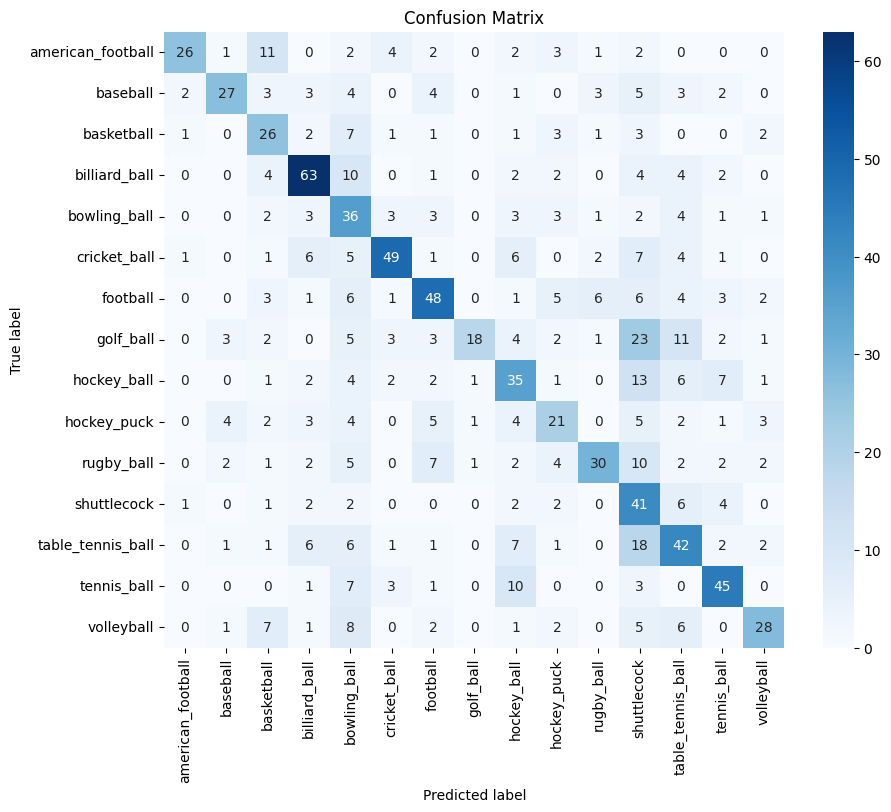

In [10]:

modell.eval()  # tryb ewaluacji
all_preds = []
all_labels = []

with torch.no_grad():
    for Xbatch, ybatch in validation_loader:
        outputs = modell(Xbatch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(ybatch.cpu().numpy())

# Macierz pomyłek
cm = confusion_matrix(all_labels, all_preds)


class_names = [str(i) for i in range(cm.shape[0])]  
class_names=train_dataset.classes
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()


In [6]:
modell = ResNet(ResidualBlock, [3,4,6,3])
modell.load_state_dict(torch.load("ResNet_50_accuracy.pth"))
modell.eval()

<All keys matched successfully>

In [11]:
from sklearn.metrics import precision_score

precision = precision_score(all_labels, all_preds, average=None)  


for i, p in enumerate(precision):
    print(f"{class_names[i]}: Precision = {p:.4f}")


american_football: Precision = 0.8387
baseball: Precision = 0.6923
basketball: Precision = 0.4000
billiard_ball: Precision = 0.6632
bowling_ball: Precision = 0.3243
cricket_ball: Precision = 0.7313
football: Precision = 0.5926
golf_ball: Precision = 0.8571
hockey_ball: Precision = 0.4321
hockey_puck: Precision = 0.4286
rugby_ball: Precision = 0.6667
shuttlecock: Precision = 0.2789
table_tennis_ball: Precision = 0.4468
tennis_ball: Precision = 0.6250
volleyball: Precision = 0.6667


In [12]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


                   precision    recall  f1-score   support

american_football     0.8387    0.4815    0.6118        54
         baseball     0.6923    0.4737    0.5625        57
       basketball     0.4000    0.5417    0.4602        48
    billiard_ball     0.6632    0.6848    0.6738        92
     bowling_ball     0.3243    0.5806    0.4162        62
     cricket_ball     0.7313    0.5904    0.6533        83
         football     0.5926    0.5581    0.5749        86
        golf_ball     0.8571    0.2308    0.3636        78
      hockey_ball     0.4321    0.4667    0.4487        75
      hockey_puck     0.4286    0.3818    0.4038        55
       rugby_ball     0.6667    0.4286    0.5217        70
      shuttlecock     0.2789    0.6721    0.3942        61
table_tennis_ball     0.4468    0.4773    0.4615        88
      tennis_ball     0.6250    0.6429    0.6338        70
       volleyball     0.6667    0.4590    0.5437        61

         accuracy                         0.5144      